In [1]:
platformID = 'YT-'

In [2]:
from tqdm import tqdm 
from datetime import datetime

import pandas as pd
pd.set_option('display.float_format', '{:.00f}'.format)

import numpy as np

import missingno as msno

## import helper

In [3]:
from config_GAM2025 import gam_info

import test_functions 
import functions 

In [4]:
# country
pop_size_col = 'Population Size (We are social)'
pop_size_col = 'Population2020'
cols = ['PlaceID', pop_size_col]
country_codes = pd.read_excel(f"../../{gam_info['lookup_file']}", sheet_name='CountryID')[cols]

# week 
week_tester = pd.read_excel(f"../../{gam_info['lookup_file']}", 
                            sheet_name='GAM Period',)
week_tester['w/c'] = pd.to_datetime(week_tester['w/c'])

# social media accounts
socialmedia_accounts = pd.read_excel(f"../../{gam_info['lookup_file']}", 
                                     sheet_name='Social Media Accounts new')

socialmedia_accounts = socialmedia_accounts[socialmedia_accounts['Year'] == gam_info['file_timeinfo']]
socialmedia_accounts = socialmedia_accounts[socialmedia_accounts['PlatformID'] == platformID]
socialmedia_accounts = socialmedia_accounts[socialmedia_accounts['Status'] == 'active']

channel_ids = socialmedia_accounts['Channel ID'].unique().tolist()
formatted_channel_ids = ', '.join(f"'{channel_id}'" for channel_id in channel_ids)

# overlaps 
overlaps = pd.read_excel(f"../../{gam_info['lookup_file']}", sheet_name='overlap')
overlaps.head()

,Overlap Type,ServiceID,overlap_%
0,Pages Overlap Factor (Secondary),FOA,0
1,Pages Overlap Factor (Secondary),ARA,0
2,Pages Overlap Factor (Secondary),UZB,1
3,Pages Overlap Factor (Secondary),MAN,1
4,Pages Overlap Factor (Secondary),PER,0


## import data 

In [5]:
full_df = pd.read_csv(f"../data/processed/{platformID}/{gam_info['file_timeinfo']}_uniqueViewer_country.csv")
# rename / replace to the appropriate columns 
'''
- PlatformID
- YearGAE
- ServiceID
- Week Number
- Reach
'''
print(full_df.shape)

full_df = full_df.merge(country_codes, on='PlaceID', 
                        how='left', indicator=True)
print(full_df._merge.value_counts())
full_df.drop(columns=['_merge'], inplace=True)
full_df.sample()

(946413, 5)
_merge
both          946413
left_only          0
right_only         0
Name: count, dtype: int64


,w/c,PlaceID,ServiceID,Channel ID,uv_by_country,Population2020
810654,2025-02-03,IND,WOR,UCq3C4bi4MAcqTcEHkZfx3JQ,22,833710000


## functions

In [6]:
def process_overlap(data, service1, service2, grouped_service, 
                    overlap_type, overlap_service_id, platform, gam_info, path):
    """
    overlap_service_id = which service ID contains the overlap factor!
    """
    # Ensure the grouped_service key exists
    if grouped_service not in data:
        data[grouped_service] = {}

    # Extract weekly data
    df1 = data[service1]['weekly']
    df2 = data[service2]['weekly']
    
    # Concatenate
    combined_df = pd.concat([df1, df2])
    
    # Pivot
    pivot_df = pd.crosstab(
        index=[combined_df['PlaceID'], combined_df['w/c']],
        columns=combined_df['ServiceID'],
        values=combined_df['Reach'],
        aggfunc='sum'
    ).reset_index()
    
    # Fill missing values
    pivot_df[service1] = pivot_df[service1].fillna(0)
    pivot_df[service2] = pivot_df[service2].fillna(0)
    
    # Get overlap
    if overlap_type != 'sainsbury':
        overlap_df = overlaps[overlaps['Overlap Type'] == overlap_type]
        overlap_value = overlap_df.loc[overlap_df['ServiceID'] == overlap_service_id, 'overlap_%'].values[0]
        print(f"overlap applied: {overlap_value}")
        pivot_df['overlap'] = overlap_value
        
        
        # Calculate adjusted reach
        pivot_df['Reach'] = pivot_df.apply(
            lambda row: row[service1] + row[service2] * (1 - row['overlap']) 
            if row[service1] > row[service2] 
            else row[service1] * (1 - row['overlap']) + row[service2],
            axis=1
        )
    else: 
        # add population
        pivot_df = pivot_df.merge(country_codes, on='PlaceID', how='left', indicator=True)
        print(f"adding population: {pivot_df._merge.value_counts()}")
        pivot_df = pivot_df.drop(columns=['_merge'])
        
        services = [service1, service2]
        pivot_df = functions.sainsbury_formula(pivot_df, pop_size_col, 
                                      services, 'Reach')
        
    # Assign grouped service
    pivot_df['ServiceID'] = grouped_service
    
    # Export
    file_name = f"{gam_info['file_timeinfo']}_YT_{grouped_service}byCountry.xlsx"
    pivot_df.to_excel(f"../data/overlaps_datasets/{file_name}", index=None)
    
    # Weekly and annual aggregation
    data[grouped_service]['weekly'] = calculate_weekly_sumServices(pivot_df, grouped_service, platform, gam_info)
    annual_df = functions.calculate_annualy(data[grouped_service]['weekly'], platform, gam_info)
    annual_file = f"{gam_info['file_timeinfo']}_{platform}_{grouped_service}.xlsx"
    annual_df.to_excel(path + annual_file, index=None)
    data[grouped_service]['annual'] = annual_df
    
    return pivot_df, annual_df


In [7]:
def process_overlap_v2(data, service1, service2, grouped_service,
                    overlap_type, overlap_service_id, platform, gam_info, path,
                    service3=None):  # <-- Add service3 as an optional argument
    """
    overlap_service_id = which service ID contains the overlap factor!
    service3: only used for overlap_type 'sainsbury'
    """
    # Ensure the grouped_service key exists
    if grouped_service not in data:
        data[grouped_service] = {}

    # Extract weekly data
    df1 = data[service1]['weekly']
    df2 = data[service2]['weekly']
    
    # For sainsbury, include service3
    if service3 is not None:
        df3 = data[service3]['weekly']
        combined_df = pd.concat([df1, df2, df3])
        services = [service1, service2, service3]
    else:
        combined_df = pd.concat([df1, df2])
        services = [service1, service2]
    
    # Pivot
    pivot_df = pd.crosstab(
        index=[combined_df['PlaceID'], combined_df['w/c']],
        columns=combined_df['ServiceID'],
        values=combined_df['Reach'],
        aggfunc='sum'
    ).reset_index()
    
    # Fill missing values for all services
    for service in services:
        if service in pivot_df.columns:
            pivot_df[service] = pivot_df[service].fillna(0)
    
    # Get overlap
    if overlap_type != 'sainsbury':
        if grouped_service == 'EN2':
            
            pivot_df['Reach'] = np.where(
                        (pivot_df['GNL'] + pivot_df['WSE']) > pivot_df['WOR'],
                        (pivot_df['GNL'] + pivot_df['WSE']) + (0.892857142857143 * pivot_df['WOR']),
                        pivot_df['WOR'] + ((pivot_df['GNL'] + pivot_df['WSE']) * 0.952380952380952)
                    )

        else:
            overlap_df = overlaps[overlaps['Overlap Type'] == overlap_type]
            overlap_value = overlap_df.loc[overlap_df['ServiceID'] == overlap_service_id, 'overlap_%'].values[0]
            print(f"overlap applied: {overlap_value}")
            pivot_df['overlap'] = overlap_value
            
            # Calculate adjusted reach (unchanged)
            pivot_df['Reach'] = pivot_df.apply(
                lambda row: row[service1] + row[service2] * (1 - row['overlap']) 
                if row[service1] > row[service2] 
                else row[service1] * (1 - row['overlap']) + row[service2],
                axis=1
            )
        
    else: 
        # add population
        pivot_df = pivot_df.merge(country_codes, on='PlaceID', how='left', indicator=True)
        print(f"adding population: {pivot_df._merge.value_counts()}")
        pivot_df = pivot_df.drop(columns=['_merge'])
        
        # Pass all services to sainsbury_formula
        pivot_df = functions.sainsbury_formula(pivot_df, pop_size_col, services, 'Reach')
            
    # Assign grouped service
    pivot_df['ServiceID'] = grouped_service
    
    # Export
    file_name = f"{gam_info['file_timeinfo']}_YT_{grouped_service}byCountry.xlsx"
    pivot_df.to_excel(f"../data/overlaps_datasets/{file_name}", index=None)
    
    # Weekly and annual aggregation
    data[grouped_service]['weekly'] = calculate_weekly_sumServices(pivot_df, grouped_service, platform, gam_info)
    annual_df = functions.calculate_annualy(data[grouped_service]['weekly'], platform, gam_info)
    annual_file = f"{gam_info['file_timeinfo']}_{platform}_{grouped_service}.xlsx"
    annual_df.to_excel(path + annual_file, index=None)
    data[grouped_service]['annual'] = annual_df
    
    return pivot_df, annual_df


# calculate 

## Business Units

### processing WSL ######################################################
{'Service IDs': ['AFA', 'FRE', 'AMH', 'ARA', 'AZE', 'BEN', 'POR', 'BUR', 'MAN', 'DAR', 'FAR', 'KRW', 'GUJ', 'HAU', 'HIN', 'IGB', 'INO', 'KOR', 'KYR', 'ELT', 'MAR', 'SPA', 'NEP', 'PAS', 'PER', 'PDG', 'PUN', 'RUS', 'SER', 'SIN', 'SOM', 'SWA', 'TAM', 'TEL', 'THA', 'TIG', 'TUR', 'ECH', 'UKR', 'URD', 'UZB', 'VIE', 'YOR'], 'exclude_UK': False, 'sainsbury': {'TWI': False, 'YT-': False, 'FBE': False, 'TTK': False, 'INS': False}}
sainsbury is skipped 
saved weekly file for WSL as:
 weekly/GAM2025_WEEKLY_YT-_WSLbyCountry.xlsx
calculating annual by the new method
saved annual file for WSL as:
 GAM2025_YT-_WSL.xlsx
### processing GNL ######################################################
{'Service IDs': ['GNL'], 'sainsbury': {'TWI': False, 'YT-': True, 'FBE': False, 'TTK': True, 'INS': False}}
sainsbury is applied
saved weekly file for GNL as:
 weekly/GAM2025_WEEKLY_YT-_GNLbyCountry.xlsx
calculating annual by the new method


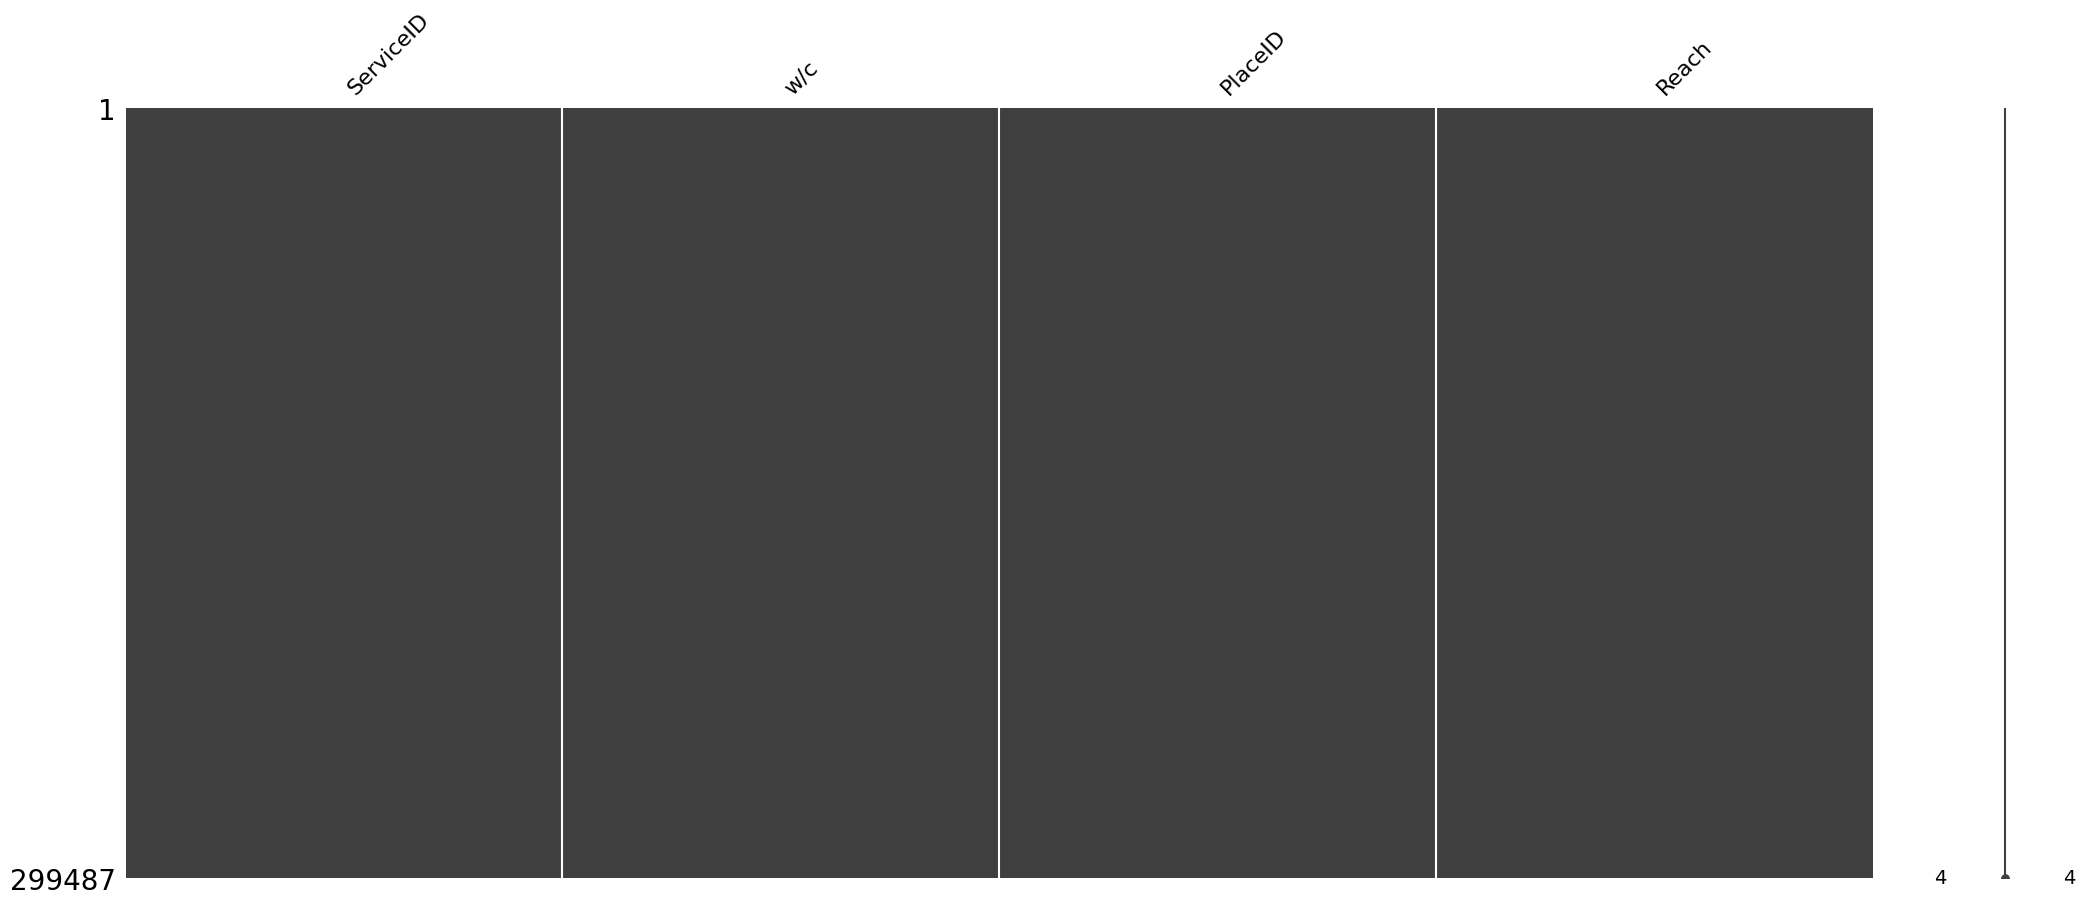

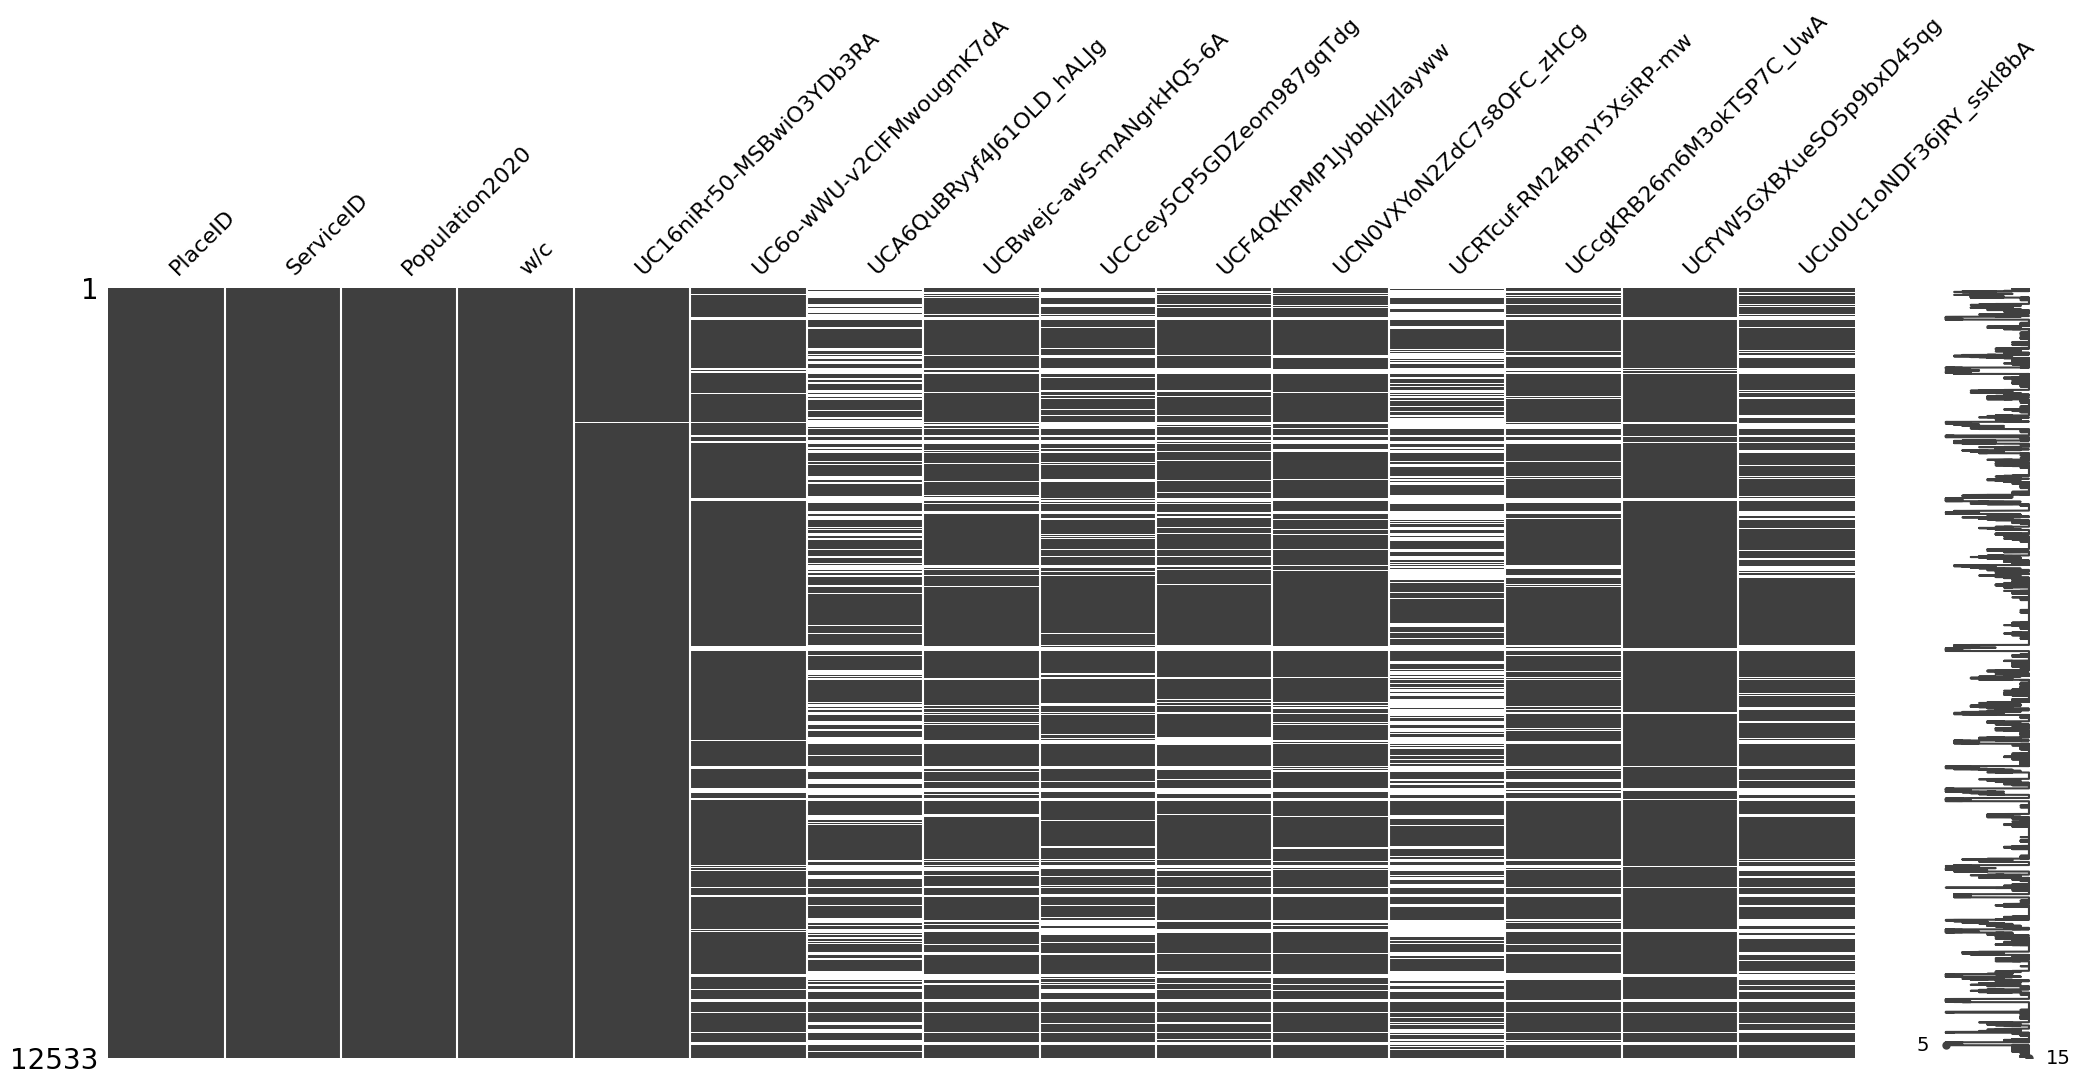

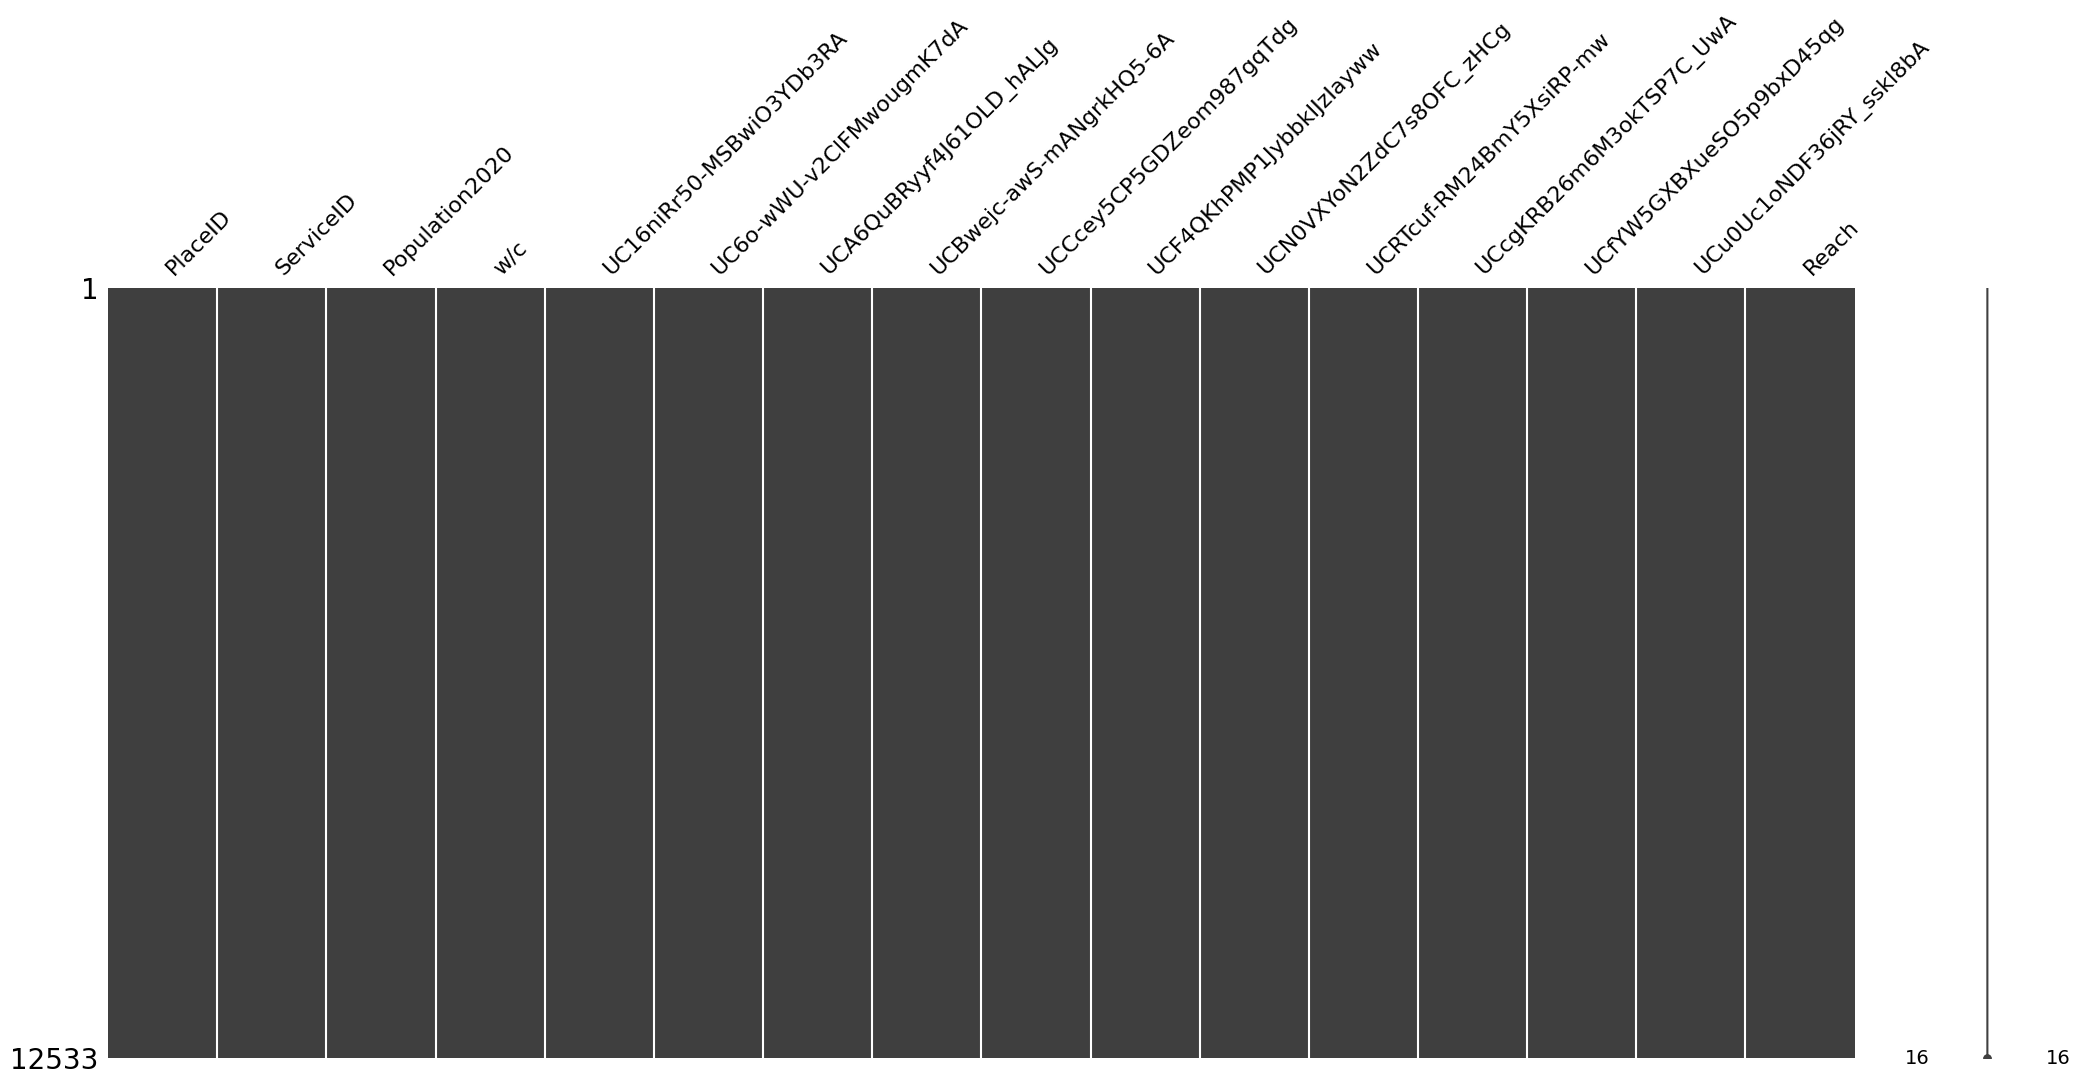

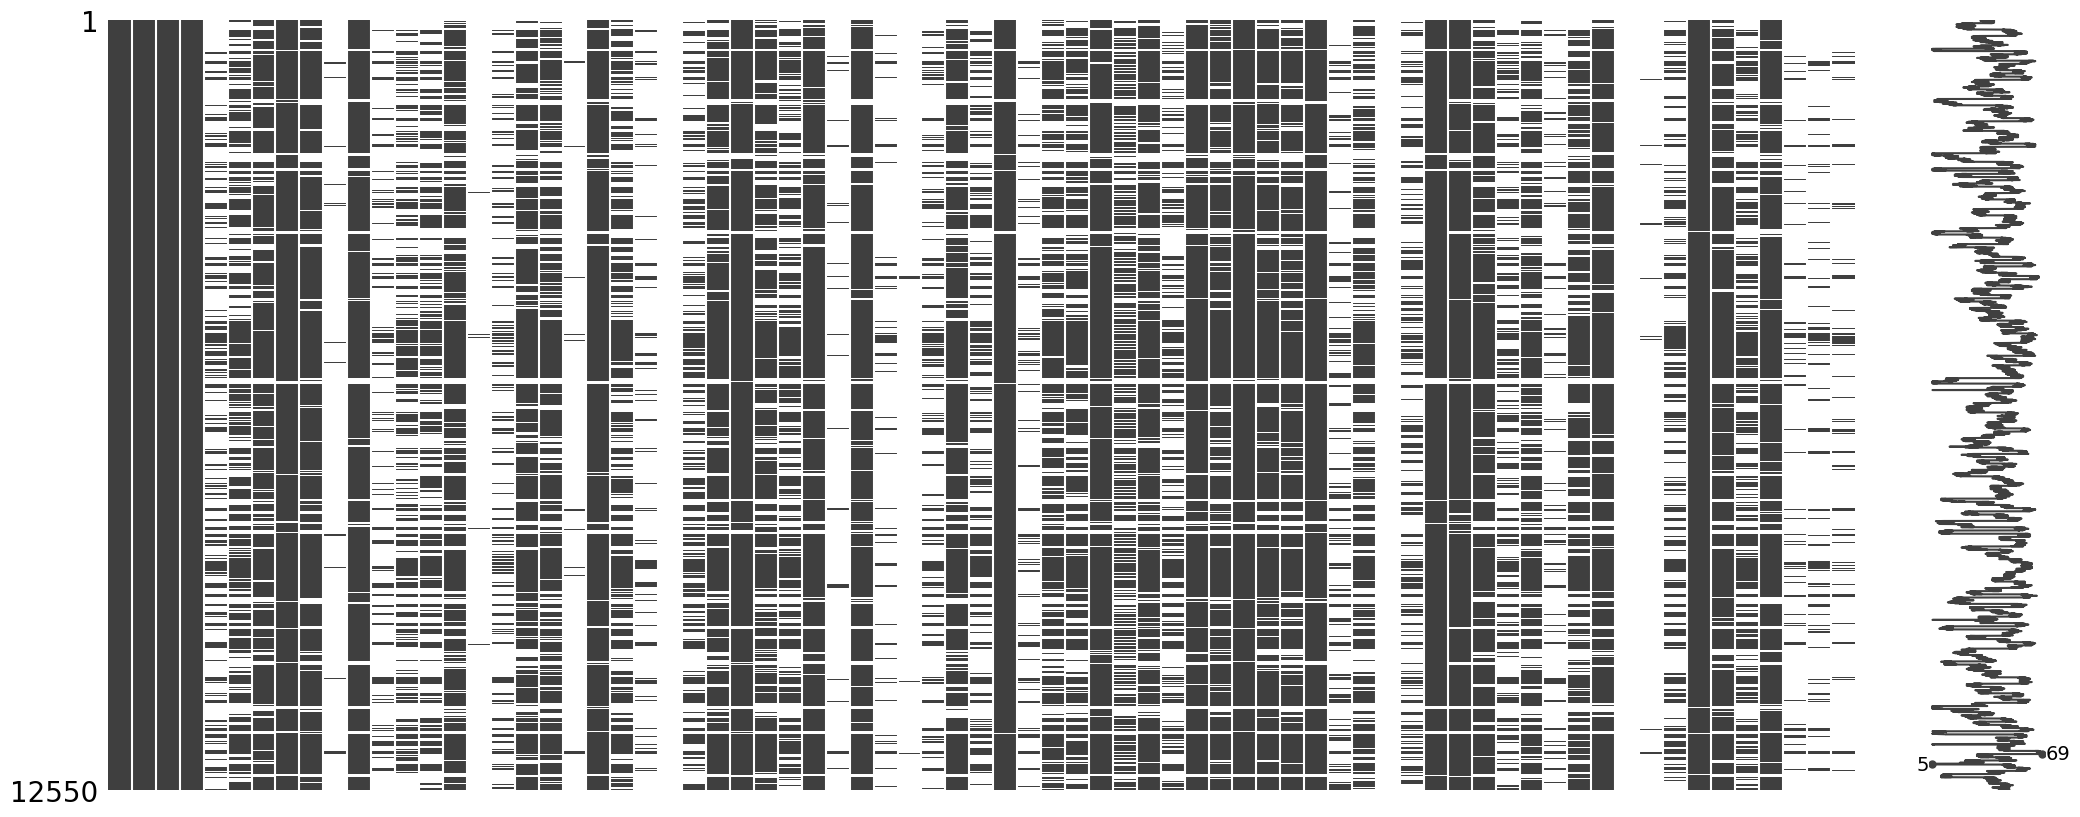

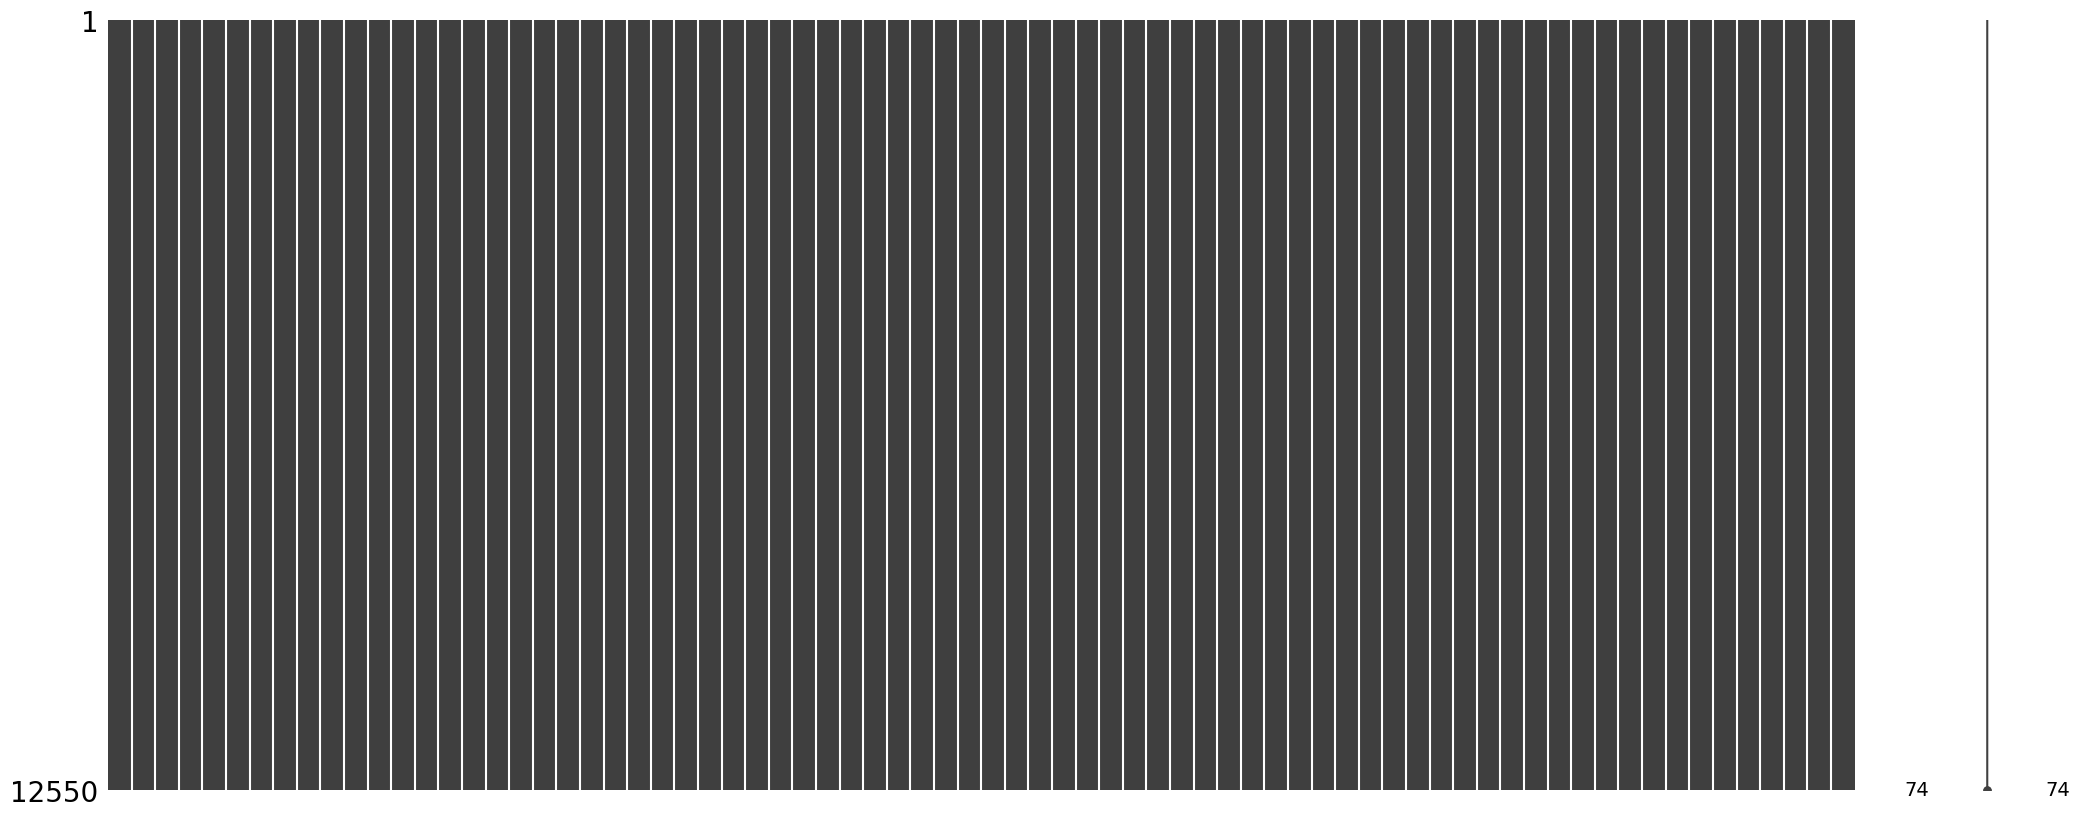

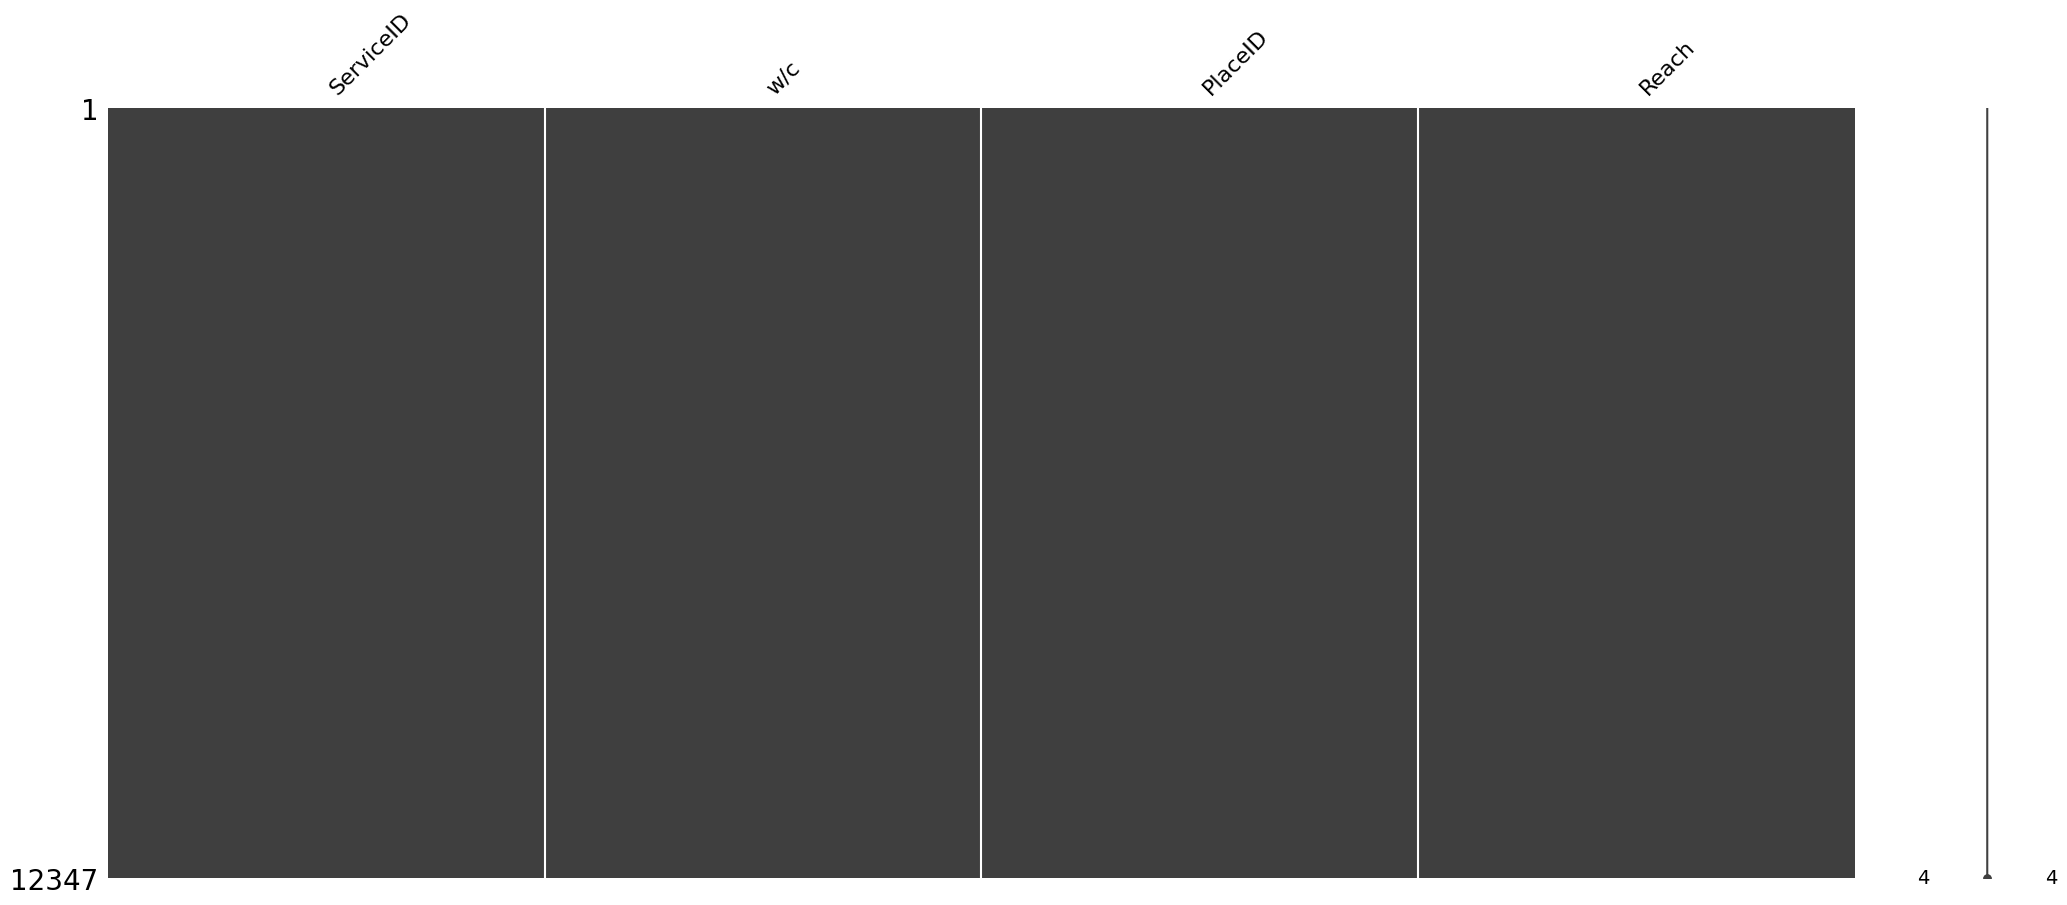

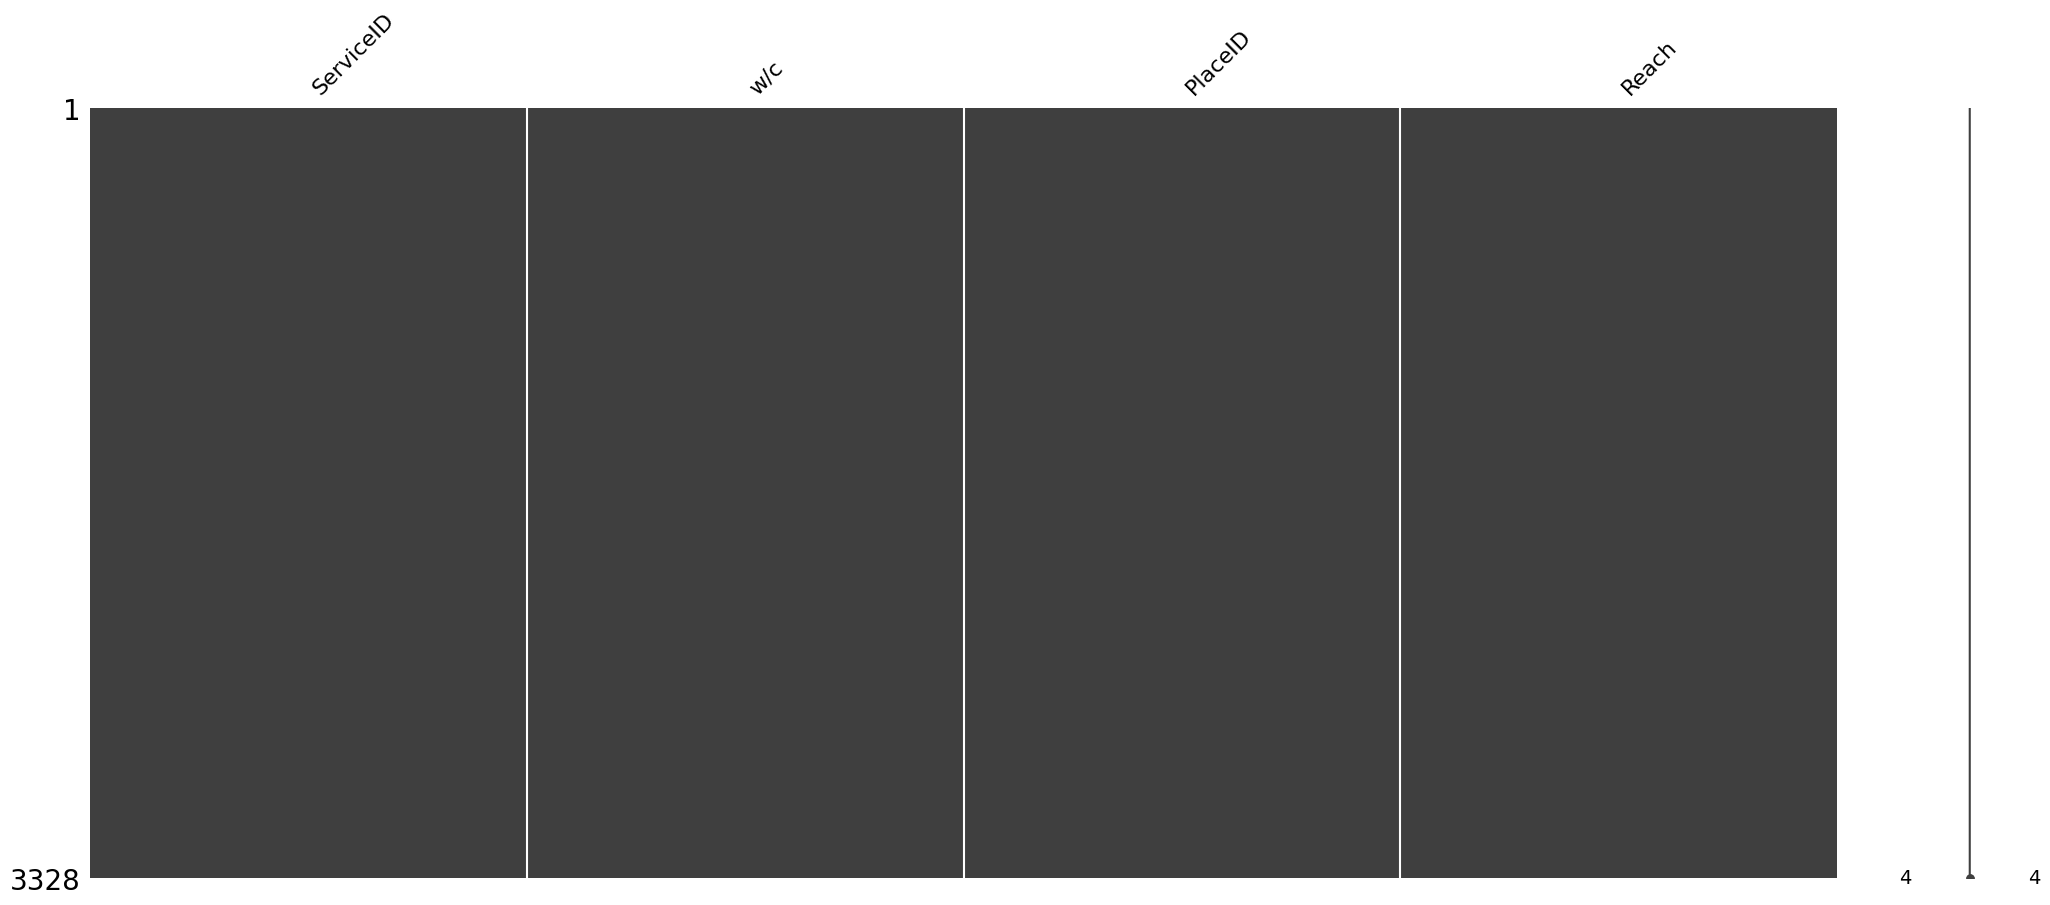

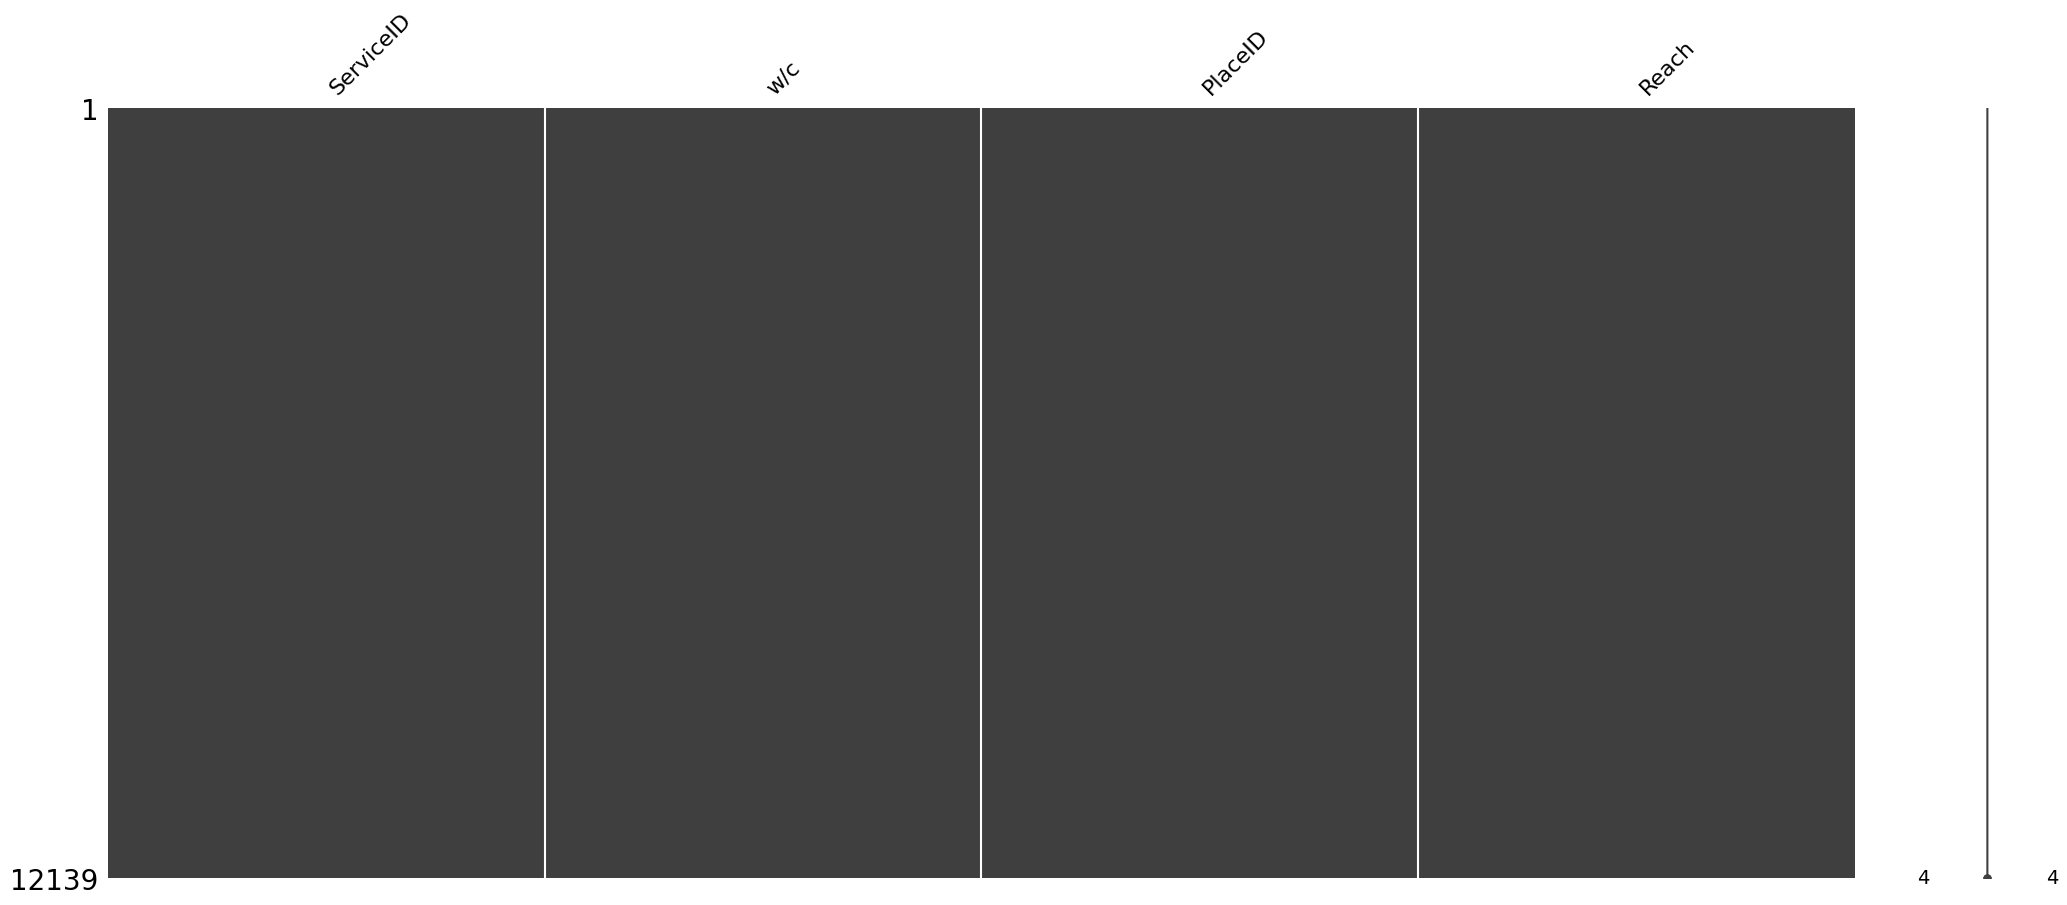

In [8]:
platform = 'YT-'
data = {}
#temp_bus = ['WOR']#['WSL', 'GNL','Studios', 'WSE', 'MA-', 'FOA']
#for bu in temp_bus:
for bu in gam_info['business_units'].keys():
    print(f"### processing {bu} ######################################################")
    data[bu] = {'weekly': 'tbd', 
                'annual': 'tbd'}
    
    bu_configs = gam_info['business_units'][bu]
    print(bu_configs)
    df = full_df[full_df['ServiceID'].isin(gam_info['business_units'][bu]['Service IDs'])]
    
    if df.empty:
        print(f"no data yet for {bu}")
        
        
    channel_ids = df['Channel ID'].unique().tolist()
    
    # will include / exclude the uk based on bu_configs
    df = functions.include_uk_decision(df, socialmedia_accounts)
    
    # for later testing or if sainsbury isn't used 
    summed_uv_by_country = df.groupby(['ServiceID', 'w/c', 'PlaceID'])\
                                .agg({'uv_by_country': 'sum'})\
                                .reset_index()
    
    if bu_configs['sainsbury'][platform]:
        print('sainsbury is applied')
        # pivot 
        channel_uv_by_country = pd.crosstab(
                                        index = [ df['PlaceID'], 
                                                  df['ServiceID'], 
                                                  df[pop_size_col], 
                                                  df['w/c']],
                                        columns = df['Channel ID'],
                                        values =  df['uv_by_country'],
                                        aggfunc='sum'
                                    ).reset_index()
    
        # check for missing values
        # especially in the string columns no values should be missing
        msno.matrix(channel_uv_by_country)
        
        # fill missing values with 0 - this is good fi the matrix above showed that the string 
        # columns did not have any missings so the only gaps filled are numeric. 
        channel_uv_by_country = channel_uv_by_country.fillna(0)
        
        #calculate sainsbury
        channel_uv_by_country = functions.sainsbury_formula(channel_uv_by_country, pop_size_col, 
                                      channel_ids, 'uv_by_country')
        
        cols_left =  ['w/c', 'PlaceID', 'uv_by_country']
        cols_right = ['w/c', 'PlaceID', 'ServiceID', 'uv_by_country']
        #yt_deduped = channel_uv_by_country[cols_left].merge(summed_uv_by_country[cols_right], on=['w/c', 'PlaceID'], how='inner')
        yt_deduped = channel_uv_by_country.rename(columns={'uv_by_country': 'Reach'})
        
    else:
        print('sainsbury is skipped ')
        # instead of pivot we can use the summed df above that already contains the sum over 
        # YT Service Code so the channels are already summarised in Services
        yt_deduped = summed_uv_by_country.rename(columns={'uv_by_country': 'Reach'})
    
    # processing 
    weekly_df, annual_df = functions.summary_excel(yt_deduped, bu, platform, gam_info)
    
    # storing data
    data[bu]['weekly'] = weekly_df
    data[bu]['annual'] = annual_df
    
    

## AXE

In [9]:
grouped_service = 'AXE'
data[grouped_service] = {'weekly': 'tbd',
                         'annual': 'tbd'}
    

### weekly 

In [10]:
def calculate_weekly_sumServices(df, serviceID, platform, gam_info):
    
    # temporary to explain discrepancy to minnie's values
    df_weekly = df.groupby(['PlaceID', 'w/c'])['Reach'].sum().reset_index()
    df_weekly['Reach'] = df_weekly['Reach']
    df_weekly['ServiceID'] = serviceID
    df_weekly['PlatformID'] = platform
    df_weekly['YearGAE'] = gam_info['YearGAE']
    
    path = "../data/singlePlatform/output/"
    file_path = f"weekly/{gam_info['file_timeinfo']}_WEEKLY_{platform}_{serviceID}byCountry.xlsx"
    
    col_order = ['YearGAE', 'ServiceID', 'PlatformID', 'PlaceID', 'w/c', 'Reach']
    df_weekly.to_excel(path+file_path, index=None)
    
    return df_weekly
wsl_weekly = data['WSL']['weekly']
wsl_weekly = wsl_weekly[~wsl_weekly['ServiceID'].isin(['SER', 'SIN'])]

data[grouped_service]['weekly'] = calculate_weekly_sumServices(wsl_weekly, grouped_service, platform, gam_info)


### annualy

In [11]:
axe_annual = functions.calculate_annualy(data[grouped_service]['weekly'], platform, gam_info)#, aggregation_type='old')
path = "../data/singlePlatform/output/"
file_path = f"{gam_info['file_timeinfo']}_{platform}_{grouped_service}.xlsx"
axe_annual.to_excel(path+file_path, index=None)
data[grouped_service]['annual'] = axe_annual
file_path

calculating annual by the new method


'GAM2025_YT-_AXE.xlsx'

## AX2
(WSL + Africa)


In [12]:
grouped_service = 'AX2'
data[grouped_service] = {'weekly': 'tbd',
                         'annual': 'tbd'}
    

In [13]:
pivot_ax, annual_ax = process_overlap(
    data=data,
    service1='FOA',
    service2='AXE',
    grouped_service='AX2',
    overlap_type='WSL/FOA',
    overlap_service_id='FOA',
    platform=platform,
    gam_info=gam_info,
    path=path
)



overlap applied: 0.035686
calculating annual by the new method


## ANW
- [ ] join WSE & AX2

In [14]:
grouped_service = 'ANW'
data[grouped_service] = {'weekly': 'tbd',
                         'annual': 'tbd'}
    
pivot_anw, annual_anw = process_overlap(
    data=data,
    service1='AX2',
    service2='WSE',
    grouped_service='ANW',
    overlap_type='WSE/WSL',
    overlap_service_id='AXE',
    platform=platform,
    gam_info=gam_info,
    path=path
)


overlap applied: 0.071933
calculating annual by the new method


## ANY 
WS + GN

In [15]:
grouped_service = 'ANY'
data[grouped_service] = {'weekly': 'tbd',
                         'annual': 'tbd'}

pivot_any, annual_any = process_overlap(
    data=data,
    service1='GNL',
    service2='ANW',
    grouped_service='ANY',
    overlap_type='WSL/GNL',
    overlap_service_id='ANW',
    platform=platform,
    gam_info=gam_info,
    path=path
)


overlap applied: 0.106934
calculating annual by the new method


## TOT 
WS GNL MA

In [16]:
grouped_service = 'TOT'
data[grouped_service] = {'weekly': 'tbd',
                         'annual': 'tbd'}

pivot_any, annual_any = process_overlap(
    data=data,
    service1='MA-',
    service2='ANY',
    grouped_service='TOT',
    overlap_type='sainsbury',
    overlap_service_id='-',
    platform=platform,
    gam_info=gam_info,
    path=path
)


adding population: _merge
both          12669
left_only         0
right_only        0
Name: count, dtype: int64
calculating annual by the new method


## ALL
TOT + WOR

In [17]:
grouped_service = 'ALL'
data[grouped_service] = {'weekly': 'tbd',
                         'annual': 'tbd'}

pivot_any, annual_any = process_overlap(
    data=data,
    service1='TOT',
    service2='WOR',
    grouped_service='ALL',
    overlap_type='sainsbury',
    overlap_service_id='-',
    platform=platform,
    gam_info=gam_info,
    path=path
)


adding population: _merge
both          12719
left_only         0
right_only        0
Name: count, dtype: int64
calculating annual by the new method


## ENG
GNL + WSE

In [18]:
grouped_service = 'ENG'
data[grouped_service] = {'weekly': 'tbd',
                         'annual': 'tbd'}

pivot_any, annual_any = process_overlap(
    data=data,
    service1='GNL',
    service2='WSE',
    grouped_service=grouped_service,
    overlap_type='sainsbury',
    overlap_service_id='-',
    platform=platform,
    gam_info=gam_info,
    path=path
)


adding population: _merge
both          12623
left_only         0
right_only        0
Name: count, dtype: int64
calculating annual by the new method


## EN2
GNL + WSE + WOR

In [19]:
grouped_service = 'EN2'
data[grouped_service] = {'weekly': 'tbd',
                         'annual': 'tbd'}

pivot_any, annual_any = process_overlap_v2(
    data=data,
    service1='GNL',
    service2='WSE',
    grouped_service=grouped_service,
    overlap_type='other',
    overlap_service_id='-',
    platform=platform,
    gam_info=gam_info,
    path=path,
    service3='WOR'
)


calculating annual by the new method


## ENW

WSE + FOA

In [26]:
grouped_service = 'ENW'
data[grouped_service] = {'weekly': 'tbd',
                         'annual': 'tbd'}

pivot_any, annual_any = process_overlap(
    data=data,
    service1='WSE',
    service2='FOA',
    grouped_service=grouped_service,
    overlap_type='sainsbury',
    overlap_service_id='-',
    platform=platform,
    gam_info=gam_info,
    path=path
)


adding population: _merge
both          12413
left_only         0
right_only        0
Name: count, dtype: int64
calculating annual by the new method


# Consolidation

In [29]:
consolidated_dfs = []
for service in data.keys():
    consolidated_dfs.append(data[service]['annual'])
consolidated_df = pd.concat(consolidated_dfs)
consolidated_df.head()

,YearGAE,ServiceID,PlatformID,PlaceID,Reach
0,2025,ARA,YT-,Total,5004403
1,2025,AZE,YT-,Total,516301
2,2025,BEN,YT-,Total,3381822
3,2025,BUR,YT-,Total,1162008
4,2025,ECH,YT-,Total,22


In [33]:
totals = consolidated_df[consolidated_df['PlaceID'] == 'Total']
non_totals = consolidated_df[consolidated_df['PlaceID'] != 'Total']

In [34]:
consolidated_df.ServiceID.unique()

array(['ARA', 'AZE', 'BEN', 'BUR', 'ECH', 'ELT', 'FRE', 'GUJ', 'HAU',
       'HIN', 'INO', 'KOR', 'KYR', 'MAN', 'MAR', 'NEP', 'PAS', 'PER',
       'POR', 'PUN', 'RUS', 'SER', 'SIN', 'SOM', 'SPA', 'SWA', 'TAM',
       'TEL', 'THA', 'TUR', 'UKR', 'URD', 'UZB', 'VIE', 'GNL', 'WOR',
       'WSE', 'MA-', 'FOA', 'AXE', 'AX2', 'ANW', 'ANY', 'TOT', 'ALL',
       'ENG', 'EN2', 'ENW'], dtype=object)